# preprocess_annon_file

for pan_omics project

04/09/2020

In [52]:
import pandas as pd
import subprocess
import seaborn as sns
import pybedtools

For human, mouse, zebrafish, rat and pig, Ensembl not only shows transcripts that are annotated automatically using the Ensembl genebuild pipeline, but also transcripts that are manually annotated by the HAVANA team. If the Ensembl and Havana annotation agree with each other the transcripts are combined into an Ensembl/Havana merged transcript. When a transcript is only annotated by Ensembl or Havana it is named an Ensembl or Havana transcript, respectively. Transcripts that do match a species-specific entry in the UniProtKB/Swiss-Prot or RefSeq databases are categorised as known, those that do not as categorised as novel. For more detailed information, please have a look at our genebuild documentation.



In [6]:
tss_file = '../data/external/TSS_annon_ALL.csv'
# gencode_file = '../data/external/gene_annon_ALL.csv'
gene_annon_file = '../data/external/gencode.v19.annotation.gtf'

In [39]:
%%time
gene_annon_df = pd.read_csv(gene_annon_file, header=None, skiprows=5,sep='\t')
gene_annon_df.columns = ['chr','annotation_source', 'type', 'start','end','qual','strand', 'misc', 'gene_info']
gene_annon_df=gene_annon_df[gene_annon_df.type=='gene']
#this line takes awhile
gene_annon_df[['ensg_id','enst_id','gene_type','status','gene_sym']] = gene_annon_df.gene_info.str.split('[ ";]',expand=True).loc[:,[2,7,12,17,22]]
gene_annon_df.shape#(57820, 14)

CPU times: user 11.1 s, sys: 446 ms, total: 11.6 s
Wall time: 10.4 s


In [59]:
gene_annon_df_file = gene_annon_df[['chr','start','end','gene_sym']]
gene_annon_df_file.to_csv('../data/external/gencode.v19.gene.bed',sep='\t',header=None,index=None)

In [9]:
exon_annon_df = pd.read_csv(gene_annon_file, header=None, skiprows=5,sep='\t')
exon_annon_df.columns = ['chr','annotation_source', 'type', 'start','end','qual','strand', 'misc', 'gene_info']
exon_annon_df=exon_annon_df[exon_annon_df.type=='exon']
#this line takes awhile
exon_annon_df[['ensg_id','enst_id','gene_type','status','gene_sym']] = exon_annon_df.gene_info.str.split('[ ";]',expand=True).loc[:,[2,7,12,17,22]]#(1196293, 14)

In [55]:
exon_annon_df_filt = exon_annon_df[['chr','start','end','gene_sym']]

In [57]:
exon_annon_df_filt.to_csv('../data/external/gencode.v19.exon.bed',sep='\t',header=None,index=None)

In [43]:
exon_annon_df.shape

(1196293, 14)

In [41]:
exon_annon_df[:5]

,chr,annotation_source,type,start,end,qual,strand,misc,gene_info,ensg_id,enst_id,gene_type,status,gene_sym
2,chr1,HAVANA,exon,11869,12227,.,+,.,"gene_id ""ENSG00000223972.4""; transcript_id ""EN...",ENSG00000223972.4,ENST00000456328.2,pseudogene,KNOWN,DDX11L1
3,chr1,HAVANA,exon,12613,12721,.,+,.,"gene_id ""ENSG00000223972.4""; transcript_id ""EN...",ENSG00000223972.4,ENST00000456328.2,pseudogene,KNOWN,DDX11L1
4,chr1,HAVANA,exon,13221,14409,.,+,.,"gene_id ""ENSG00000223972.4""; transcript_id ""EN...",ENSG00000223972.4,ENST00000456328.2,pseudogene,KNOWN,DDX11L1
6,chr1,ENSEMBL,exon,11872,12227,.,+,.,"gene_id ""ENSG00000223972.4""; transcript_id ""EN...",ENSG00000223972.4,ENST00000515242.2,pseudogene,KNOWN,DDX11L1
7,chr1,ENSEMBL,exon,12613,12721,.,+,.,"gene_id ""ENSG00000223972.4""; transcript_id ""EN...",ENSG00000223972.4,ENST00000515242.2,pseudogene,KNOWN,DDX11L1


In [54]:
gene_annon_df.gene_type.value_counts()

protein_coding              20345
pseudogene                  13931
lincRNA                      7114
antisense                    5276
miRNA                        3055
misc_RNA                     2034
snRNA                        1916
snoRNA                       1457
sense_intronic                742
rRNA                          527
processed_transcript          515
sense_overlapping             202
IG_V_pseudogene               187
IG_V_gene                     138
TR_V_gene                      97
TR_J_gene                      74
polymorphic_pseudogene         45
IG_D_gene                      37
TR_V_pseudogene                27
Mt_tRNA                        22
3prime_overlapping_ncrna       21
IG_J_gene                      18
IG_C_gene                      14
IG_C_pseudogene                 9
TR_C_gene                       5
TR_J_pseudogene                 4
IG_J_pseudogene                 3
TR_D_gene                       3
Mt_rRNA                         2
Name: gene_typ

count    5.782000e+04
mean     2.990738e+04
std      8.709646e+04
min      7.000000e+00
25%      4.710000e+02
50%      2.782500e+03
75%      2.262200e+04
max      2.304637e+06
dtype: float64


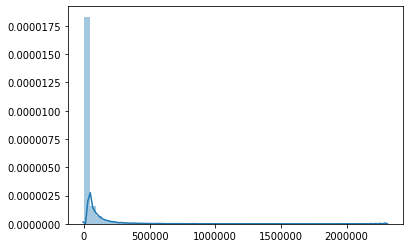

In [53]:
# gene lengths
print((gene_annon_df.end-gene_annon_df.start).describe())
sns.distplot((gene_annon_df.end-gene_annon_df.start))

In [49]:
gene_annon_df.annotation_source.value_counts()#.value_counts()

HAVANA     47970
ENSEMBL     9850
Name: annotation_source, dtype: int64

In [5]:
# make gencode list
# gencode_df = pd.read_csv(gencode_file,index_col=0)
# gencode_df.columns = ['chr', 'start', 'end', 'width', 'strand', 'gene']
# gencode_df['chr'] = 'chr' + gencode_df['chr'].astype(str)
# gencode_df[:5]

FileNotFoundError: [Errno 2] File b'../data/external/gene_annon_ALL.csv' does not exist: b'../data/external/gene_annon_ALL.csv'

In [152]:
# make tss list
tss_df = pd.read_csv(tss_file,index_col=0)
tss_df.columns = ['chr', 'start', 'end', 'width', 'strand', 'TSS']
tss_df['chr'] = 'chr' + tss_df['chr'].astype(str)
tss_df.sort_values('chr',inplace=True)
tss_df.reset_index(drop=True,inplace=True)
tss_df[:5]

,chr,start,end,width,strand,TSS
0,chr1,1846266,1846266,1,*,CALML6
1,chr1,231376933,231376933,1,*,C1orf131
2,chr1,241683061,241683061,1,*,FH
3,chr1,120202421,120202421,1,*,PHGDH
4,chr1,204135465,204135465,1,*,REN


In [153]:
check_tss_unique = pd.DataFrame(tss_df.groupby("TSS")['end'].nunique())
print(check_tss_unique.shape)
print(check_tss_unique[check_tss_unique.end>1].index.shape)
check_tss_unique[check_tss_unique.end>1].index.sort_values()

(20178, 1)
(69,)


Index(['ACE', 'ALG9', 'ANKRD18A', 'CCDC177', 'CDRT1', 'CELF6', 'CHTF8',
       'CKS1B', 'CLN3', 'CRIP1', 'CRYBG3', 'DEFB130', 'FAM47E-STBD1', 'GALT',
       'GOLGA7B', 'HOXC4', 'IER3IP1', 'ITFG3', 'ITGB3', 'KBTBD4', 'KIAA0391',
       'KLK9', 'KRBOX1', 'KRT222', 'LCN6', 'LIMS3', 'LSP1', 'LTB4R2', 'MDGA2',
       'MFRP', 'MRPL30', 'MRPS17', 'MUC3A', 'NAA60', 'NDUFA7', 'NDUFB8',
       'NPIPA7', 'OC90', 'PAGR1', 'PIK3R2', 'POLR2J2', 'PSMA1', 'PSMA2',
       'RBL1', 'RNASE11', 'RPP14', 'SDHD', 'SEPT1', 'SHPK', 'SIGLEC5',
       'SLC25A10', 'SNURF', 'SOGA3', 'TAP2', 'TIMM10B', 'TLR9', 'TM4SF19',
       'TMBIM4', 'TMEM236', 'TUBB3', 'UGT2A1', 'UQCR11', 'ZFP41', 'ZNF223',
       'ZNF286A', 'ZNF668', 'ZNF709', 'ZNF747', 'ZNF8'],
      dtype='object', name='TSS')

 note that there are 69 of 20178 unique TSS symbols that have two TSS locations, there is some discrepancy as to where those TSS's actually are located so we'll just use both and not this for future reference

In [209]:
PROMOTER_LEN_UPSTREAM=2000
PROMOTER_LEN_DOWNSTREAM=500

In [210]:
promoter_df = tss_df
promoter_df['start_n']= promoter_df['start'].map(int) - PROMOTER_LEN_UPSTREAM
promoter_df['end_n']= promoter_df.end + PROMOTER_LEN_DOWNSTREAM
promoter_df = promoter_df[['chr','start_n','end_n','TSS']]

In [211]:
promoter_df[:5]

,chr,start_n,end_n,TSS
0,chr1,1834266,1836766,CALML6
1,chr1,231364933,231367433,C1orf131
2,chr1,241671061,241673561,FH
3,chr1,120190421,120192921,PHGDH
4,chr1,204123465,204125965,REN


In [212]:
promoter_df.to_csv('promoter_hg19_{}_{}.bed'.format(PROMOTER_LEN_UPSTREAM,PROMOTER_LEN_DOWNSTREAM),
                   header=None,index=None,sep='\t')
                   

In [213]:
# cmd = "bedtools sort -i promoter_hg19_5000_5000.bed"
# cmd_arr = cmd.split(' ')
# print(cmd_arr)
# with open("promoter_hg19_2500_500_sort.bed", "w") as file:
#     subprocess.run(cmd_arr, shell=True, check=True, stdout=file)

In [214]:
promoter = pybedtools.BedTool('promoter_hg19_{}_{}.bed'.format(PROMOTER_LEN_UPSTREAM,PROMOTER_LEN_DOWNSTREAM))

promoter.sort().saveas('promoter_hg19_{}_{}_sort.bed'.format(PROMOTER_LEN_UPSTREAM,PROMOTER_LEN_DOWNSTREAM))



<BedTool(promoter_hg19_2000_500_sort.bed)>

# fix tf annotation file

In [47]:
rna_tpm_file = '../rnaseq/tissue_tpm_sym.csv'
rna_df = pd.read_csv(rna_tpm_file, index_col=0,header=0)
rna_df.index = [x.upper() for x in rna_df.index.values]
def get_exp(rna_df, sym, tissue,verbose=True):
    try:
        return rna_df.loc[sym,tissue]
    except KeyError:
        if verbose:
            print(sym, 'not found')
        return 0


In [72]:
hoco_annon_file = 'HOCOMOCOv11_core_annotation_HUMAN_mono.tsv'
hoco_annon = pd.read_table(hoco_annon_file,header=0)
# hoco_annon[['motif_abbr','motif_info']]=hoco_annon['Model'].str.split("_",expand=True)
hoco_id_to_tf = pd.Series(hoco_annon['Transcription factor'].values, index=hoco_annon.Model.values).to_dict()
# hoco_df = pd.read_table(hoco_annon_file, index_col=None, 
#                             names=['anchor_chr', 'anchor_start', 'anchor_end', 
#                                     'foot_chr', 'foot_start', 'foot_end', 'motif', 'score', 'strand'])
# hoco_df['transcription_factor'] = hoco_df['motif'].map(hoco_motif_to_tf)

In [73]:
# check to see if the rna expression for these tfs is in the table
for motif, tf in hoco_id_to_tf.items():
    exp = get_exp(rna_df, tf, 'GDSD0')
    if type(exp)==int:
        print(motif, tf)
        

T not found
BRAC_HUMAN.H11MO.0.A T
HNF1B not found
HNF1B_HUMAN.H11MO.0.A HNF1B
MEF2B not found
MEF2B_HUMAN.H11MO.0.A MEF2B
NR2E3 not found
NR2E3_HUMAN.H11MO.0.C NR2E3
ZNF8 not found
ZNF8_HUMAN.H11MO.0.C ZNF8


In [74]:
len(hoco_motif_to_tf)
401

401

So of the 401 human Transcription factors in HOCOMOCO,5 are not found in RNA_df by direct lookup, By manual search we find the following mappings

-  BRAC_HUMAN.H11MO.0.A, T --> TBXT
- HNF1B_HUMAN.H11MO.0.A --> n/a
- MEF2B_HUMAN.H11MO.0.A --> n/a
- NR2E3_HUMAN.H11MO.0.C --> n/a
- ZNF8_HUMAN.H11MO.0.C --> ZNF8-ERVK3-1

In [75]:
# manual correction of mapping dict
hoco_id_to_tf['BRAC_HUMAN.H11MO.0.A'] = 'TBXT'
hoco_id_to_tf['ZNF8_HUMAN.H11MO.0.C'] = 'ZNF8-ERVK3-1'
for motif, tf in hoco_id_to_tf.items():
    exp = get_exp(rna_df, tf, 'GDSD0')
    if type(exp)==int:
        print(motif, tf)
        

HNF1B not found
HNF1B_HUMAN.H11MO.0.A HNF1B
MEF2B not found
MEF2B_HUMAN.H11MO.0.A MEF2B
NR2E3 not found
NR2E3_HUMAN.H11MO.0.C NR2E3


In [76]:
hoco_id_to_tf = pd.DataFrame(pd.Series(hoco_id_to_tf).reset_index())
hoco_id_to_tf.columns=['id','tf']


In [78]:
hoco_id_to_tf[:5]

,id,tf
0,AHR_HUMAN.H11MO.0.B,AHR
1,AIRE_HUMAN.H11MO.0.C,AIRE
2,ALX1_HUMAN.H11MO.0.B,ALX1
3,ANDR_HUMAN.H11MO.0.A,AR
4,AP2A_HUMAN.H11MO.0.A,TFAP2A


In [79]:
hoco_id_to_tf.to_csv('HOCOMOCOv11_annotation.csv')